# LUMI-G cupy + mpi4py benchmarks
The notebook is a continuation of this [LUMI-C OSU mpi4py benchmarks](https://github.com/DeiC-HPC/cotainr/blob/2025.7.1/examples/LUMI/conda_mpi4py_mpich/lumi_mpi4py_osu_results.ipynb) where we first introduce the new open source test methods (containers), then we extend the tests to include MPI inter-node GPU-to-GPU communication using CuPy array buffers.

The OSU benchmarks used are:
- OMB Python MPI Allgather Test: 3 processes, NumPy / CuPy buffers, single and multi node (3 nodes, 1 process each)
- OMB-Py MPI Bandwidth Test: 2 processes, NumPy / CuPy buffers, single and multi node (2 nodes, 1 process each)
- OMB Python MPI Latency Test: 2 processes, NumPy / CuPy buffers, single and multi node (2 nodes, 1 process each)

The test methods are based on two near identical base containers:
- **opensource_base_image_libcxi_libfabric1220_mpich423.sif** with MPICH 4.2.3 and libfabric 1.22.0
- **opensource_base_image_libcxi_libfabric2000_mpich423.sif** with MPICH 4.2.3 and libfabric 2.0

The final container is created using cotainr and these conda environment specifications:
They all contain Python 3.12 and mpich 4.2.3
- **mpi4py_mpich4_pip.yml** pip installed mpi4py version 4.1.0 with conda installed mpich (Most similar to previous experiments)
- **mpi4py_mpich4_conda.yml** conda installed mpi4py version 4.0.3 with conda installed mpich
- **mpi4py_mpich4_ext.yml** conda installed mpi4py version 4.0.3 using external mpich through conda `mpich=external_*`
- **cupy_mpi4py.yml** pip installed mpi4py version 4.1.0 using external mpich and cupy is compiled against the external mpich

There is an additional variable that is called HMEM here, which indicates the following exported environment variables
- `HMEM = hmem`:
    - MPIR_CVAR_CH4_OFI_ENABLE_HMEM=1
    - FI_HMEM_ROCR_USE_DMABUF=0
- otherwise `HMEM = nohmem`

Finally, this notebook as been run with the `uv` environment described in the `pyproject.toml` and `uv.lock` file.

In [2]:
from pathlib import Path
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [3]:
# Test setup specification
osu_results_folder = Path("./results/")
tests = {
    "allgather": {"processes": 3, "metric": "Latency (us)", "name": "OMB Python MPI Allgather Test"},
    "bw": {"processes": 2, "metric": "Bandwidth (MB/s)", "name": "OMB-Py MPI Bandwidth Test"},
    "latency": {"processes": 2, "metric": "Latency (us)", "name": "OMB Python MPI Latency Test"},
}
raw_containers = [
    "cupy_mpi4py_libfabric2000.sif",
    "cupy_mpi4py_libfabric1220.sif",
    "mpi4py_libfabric2000_extmpich.sif",
    "mpi4py_libfabric1220_extmpich.sif",
    "mpi4py_libfabric2000_pip.sif",
    "mpi4py_libfabric1220_pip.sif",
    "mpi4py_libfabric2000_conda.sif",
    "mpi4py_libfabric1220_conda.sif",
]

# Prettify container names into parameter strings "mpi4py_libfabric1220_pip.sif" -> "mpi4py libfabric1220 pip"
containers = [c.split('.')[0].replace('_', ' ') for c in raw_containers]

In [4]:
# Helper functions
def extract_params_from_file(*, fd: Path, delimiter: str = '-') -> str:
    """
    Parses and extracts parameters from the file name
    
    Args:
        fd (Path): delimiter-separated string ending in .txt
        delimiter (str): default is hyphen '-'

    Returns:
        param_dict (dict): Extracted parameter dictionary
    """
    file_name = fd.name.split('.txt')[0]
    params = file_name.split(delimiter)
    param_dict = {"Slurmid": params[0],
                  "Benchmark": params[1],
                  "Nodes": params[2],
                  "Container": params[3].split('.')[0].replace('_', ' '),
                  "Buffer": params[4]}
    try:
        param_dict['HMEM'] = params[5]
    except:
        param_dict['HMEM'] = 'nohmem'

    try:
        param_dict['Job'] = params[6]
    except:
        param_dict['Job'] = 'lumig'
    return param_dict

In [5]:
def filter_df(df, **kwargs):
    """
    
    """
    for name, value in kwargs.items():
        if name == "Container":
            # string-compare all values to find substring in prettified container names
            # e.g. "libfabric2000" in "mpi4py libfabric2000 conda"
            df = df[[value in str(v) for v in df.values]]
        else:
            df = df[df[name] == value]

    return df

In [6]:
def read_osu_results_file(*, file_path: Path) -> pd.DataFrame:
    """
    Load the actual test/benchmark results from results file.

    Returns
    -------
    df_osu_results : pd.DataFrame
        A long-form pandas dataframe containing the results.

    Notes
    -----
    Assumes that the results file is similar to:

    # OMB Python MPI Allgather Test
    # Size (B)      Latency (us)
    1                       6.81
    2                       6.79
    4                       6.82
    ...

    I.e., it is a fixed with text file, with:
    - two header rows prefixed by "# ": 1. The name of the test, 2. The column names and units
    - a 16 character first column containing integers
    - a 12 character second column containing decimal numbers
    """
    with file_path.open(mode="r") as f:
        test_name = f.readline().removeprefix("# ").strip()
        column = f.readline().removeprefix("# ").strip()
        column_names = re.split(r"\s{2,}", column)
    osu_colspecs = [(0, 16), (16, 29)]
    osu_dtypes = {column_names[0]: "int64", column_names[1]: "float64"}
    df_osu_results = pd.read_fwf(
        file_path,
        colspecs=osu_colspecs,
        header=1,
        names=column_names,
        dtype=osu_dtypes,
    )
    params = extract_params_from_file(fd=file_path)
    df_osu_results["Benchmark"] = params['Benchmark']
    df_osu_results["Nodes"] = params['Nodes']
    df_osu_results["Container"] = params['Container']
    df_osu_results["Buffer"] = params['Buffer']
    df_osu_results["HMEM"] = params['HMEM']
    df_osu_results["Job"] = params['Job']

    return df_osu_results

In [7]:
def show_osu_pivot_table(
    *, df: pd.DataFrame, metric: str, containers: list[str]
) -> pd.DataFrame:
    """
    Create a pivot table for the OSU results dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a pivot table for.
    metric : str
        The metric used in the OSU benchmark.
    containers : list of str
        The containers in the OSU results dataframe.

    Returns
    -------
    df_pivot: pd.DataFrame
        The pivot table.
    """

    df_pivot = (
        df.pivot(index="Size (B)", columns=["Container", "Nodes", "Buffer", "HMEM", "Job"], values=[metric])
        .reindex(columns=containers, level="Container")
        .reindex(columns=["single", "multi"], level="Nodes")
        .reindex(columns=["numpy", "cupy"], level="Buffer")
        .reindex(columns=["lumig", "lumic"], level="Job")
    )
    return df_pivot

In [8]:
def barplot_osu_results(
    *, df: pd.DataFrame, benchmark: str, nodes: str,
) -> mpl.figure.Figure:
    """
    Create a barplot of OSU results dataframe.

    Create a plot of `metric` vs message size with `containers` overlaid and
    single/multi node facetted.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a barplot for.
    benchmark : str
        A string signifying either single-node run or multi-node run, "single" or "multi"

    Returns
    -------
    mpl.figure.Figure
        The barplot figure handle.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))

    palette_colors = sns.color_palette('tab10')
    palette_dict = {container: color for container, color in zip(containers, palette_colors)}
    sns.barplot(
        df,
        x="Size (B)",
        y=tests[benchmark]["metric"],
        hue="Container",
        palette=palette_dict,
        legend="brief",
        ax=ax,
    )
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_yscale("log")
    ax.legend(title="Multiple nodes" if nodes == "multi" else "Single node")

    fig.suptitle(f"LUMI-C OSU {tests[benchmark]["name"]} results - {tests[benchmark]["processes"]} processes")
    fig.tight_layout()

    return fig

In [9]:
# Load the data into a DataFrame with all results concatenated
osu_df = pd.concat(
    [
        read_osu_results_file(file_path=file_path)
        for file_path in osu_results_folder.glob("*.txt")
    ]
)
osu_df= osu_df.sort_values(by=['Container'])

# LUMI-C vs. LUMI-G CPU Bandwidth comparison

In [10]:
benchmark = "bw"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(higher is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark, Buffer="numpy", Nodes="multi"),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB-Py MPI Bandwidth Test results - 2 processes
(higher is better)


Bandwidth (MB/s)                            \
Container cupy mpi4py libfabric2000 cupy mpi4py libfabric1220   
Nodes                         multi                     multi   
Buffer                        numpy                     numpy   
HMEM                           hmem                      hmem   
Job                           lumig                     lumig   
Size (B)                                                        
1                              0.72                      0.80   
2                              1.48                      1.59   
4                              3.10                      3.21   
8                              6.19                      6.41   
16                            12.39                     12.82   
32                            24.64                     25.63   
64                            48.90                     50.96   
128                           97.59                    102.13   
256                          196.55                    197.45   
512                          393.49                    394.52   
1024                         786.71                    789.80   
2048                        1572.62                   1580.11   
4096                        3144.94                   3173.29   
8192                        6054.39                   6069.36   
16384                       7596.58                   8704.66   
32768                      15555.04                  16640.99   
65536                      20242.53                  20620.64   
131072                     21713.69                  22421.58   
262144                     22246.20                  23022.91   
524288                     22553.35                  23151.24   
1048576                    20782.41                  22944.00   
2097152                    19674.31                  22720.34   
4194304                    20101.44                  22724.18   

                                                   \
Container mpi4py libfabric2000 extmpich             
Nodes                             multi             
Buffer                            numpy             
HMEM                             nohmem             
Job                               lumig     lumic   
Size (B)                                            
1                                  0.89      1.15   
2                                  1.77      2.29   
4                                  3.54      4.56   
8                                  7.07      9.14   
16                                14.17     18.27   
32                                28.27     36.56   
64                                56.58     73.18   
128                              113.53    146.11   
256                              221.00    297.64   
512                              442.50    595.91   
1024                             885.54   1155.83   
2048                            1760.35   2383.98   
4096                            3536.20   4727.32   
8192                            6837.46   9008.82   
16384                           7706.21  17886.30   
32768                          12693.47  20733.51   
65536                          14800.78  22396.82   
131072                         18725.91  23179.24   
262144                         21961.13  23626.96   
524288                         22347.82  23835.10   
1048576                        21200.70  23942.16   
2097152                        19622.38  23988.87   
4194304                        18934.33  24025.26   

                                                                            \
Container mpi4py libfabric1220 extmpich           mpi4py libfabric2000 pip   
Nodes                             multi                              multi   
Buffer                            numpy                              numpy   
HMEM                             nohmem                             nohmem   
Job                               lumig     lumic                    lumig   
Size (B) 

In [11]:
benchmark = "bw"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(higher is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark, Buffer="numpy", Nodes="single"),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB-Py MPI Bandwidth Test results - 2 processes
(higher is better)


Bandwidth (MB/s)                            \
Container cupy mpi4py libfabric2000 cupy mpi4py libfabric1220   
Nodes                        single                    single   
Buffer                        numpy                     numpy   
HMEM                           hmem                      hmem   
Job                           lumig                     lumig   
Size (B)                                                        
1                              0.70                      0.70   
2                              1.41                      1.43   
4                              2.83                      2.87   
8                              5.71                      5.74   
16                            11.49                     11.49   
32                            23.22                     23.00   
64                            46.56                     45.90   
128                           92.24                     91.41   
256                          183.88                    182.21   
512                          365.83                    360.56   
1024                         726.01                    711.62   
2048                        1413.10                   1384.57   
4096                        2732.12                   2647.51   
8192                        4182.61                   4014.99   
16384                       4587.35                   4604.89   
32768                       6183.09                   6102.43   
65536                       7572.52                   7365.03   
131072                      8357.65                   8227.34   
262144                      8993.42                   8666.75   
524288                      8895.44                   8856.74   
1048576                     8985.16                   9061.33   
2097152                     9367.54                   9179.51   
4194304                     9509.85                   9286.42   

                                                  \
Container mpi4py libfabric2000 extmpich            
Nodes                            single            
Buffer                            numpy            
HMEM                             nohmem            
Job                               lumig    lumic   
Size (B)                                           
1                                  0.68     1.41   
2                                  1.34     2.88   
4                                  2.75     5.74   
8                                  5.54    11.56   
16                                11.15    23.02   
32                                21.60    45.86   
64                                45.29    88.69   
128                               90.70   183.65   
256                              182.03   361.98   
512                              362.89   704.58   
1024                             722.55  1226.39   
2048                            1386.20  1736.03   
4096                            2493.06  2347.09   
8192                            4094.09  2932.10   
16384                           4408.83  2967.79   
32768                           5963.80  3462.53   
65536                           7357.45  3547.38   
131072                          8417.27  3722.76   
262144                         10714.69  3722.65   
524288                         11428.53  4229.20   
1048576                         9028.96  6911.78   
2097152                         9427.61  7155.76   
4194304                         9652.73  7262.64   

                                                                           \
Container mpi4py libfabric1220 extmpich          mpi4py libfabric2000 pip   
Nodes                            single                            single   
Buffer                            numpy                             numpy   
HMEM                             nohmem                            nohmem   
Job                               lumig    lumic                    lumig   
Size (B)                                     

The external MPICH has significantly better multi-node performance and slightly worse single-node performance than the pre-compiled mpich backends. Additionally, the libfabric 1.22 is seen to have slightly better performance in CPU-CPU internode communication.

# LUMI-G

## GPU-to-GPU Bandwidth

In [12]:
benchmark = "bw"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(higher is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark, Job='lumig', Nodes='multi'),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB-Py MPI Bandwidth Test results - 2 processes
(higher is better)


Bandwidth (MB/s)                                      \
Container cupy mpi4py libfabric2000           cupy mpi4py libfabric1220   
Nodes                         multi                               multi   
Buffer                        numpy      cupy                     numpy   
HMEM                           hmem      hmem                      hmem   
Job                           lumig     lumig                     lumig   
Size (B)                                                                  
1                              0.72      0.04                      0.80   
2                              1.48      0.08                      1.59   
4                              3.10      0.16                      3.21   
8                              6.19      0.32                      6.41   
16                            12.39      0.65                     12.82   
32                            24.64      1.30                     25.63   
64                            48.90      2.60                     50.96   
128                           97.59      5.19                    102.13   
256                          196.55     83.56                    197.45   
512                          393.49    167.07                    394.52   
1024                         786.71    334.91                    789.80   
2048                        1572.62    673.77                   1580.11   
4096                        3144.94   1351.94                   3173.29   
8192                        6054.39   2660.42                   6069.36   
16384                       7596.58   5304.53                   8704.66   
32768                      15555.04  10597.93                  16640.99   
65536                      20242.53  19313.17                  20620.64   
131072                     21713.69  21408.25                  22421.58   
262144                     22246.20  22643.60                  23022.91   
524288                     22553.35  23320.47                  23151.24   
1048576                    20782.41  23640.86                  22944.00   
2097152                    19674.31  23806.46                  22720.34   
4194304                    20101.44  23888.10                  22724.18   

                                                   \
Container           mpi4py libfabric2000 extmpich   
Nodes                                       multi   
Buffer         cupy                         numpy   
HMEM           hmem                        nohmem   
Job           lumig                         lumig   
Size (B)                                            
1              0.04                          0.89   
2              0.08                          1.77   
4              0.16                          3.54   
8              0.32                          7.07   
16             0.64                         14.17   
32             1.28                         28.27   
64             2.55                         56.58   
128            5.08                        113.53   
256           84.98                        221.00   
512          170.02                        442.50   
1024         338.50                        885.54   
2048         687.55                       1760.35   
4096        1375.60                       3536.20   
8192        2690.47                       6837.46   
16384       5357.92                       7706.21   
32768      10622.51                      12693.47   
65536      19365.79                      14800.78   
131072     21405.60                      18725.91   
262144     22646.57                      21961.13   
524288     23316.95                      22347.82   
1048576    23639.45                      21200.70   
2097152    23804.76                      19622.38   
4194304    23887.13                      18934.33   

                                                                  \
Container mpi4py libfabric1220 extmpich mpi4py libfabric2000 pip   
Nodes                             multi  

In [13]:
benchmark = "bw"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(higher is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark, Job='lumig', Nodes='single'),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB-Py MPI Bandwidth Test results - 2 processes
(higher is better)


Bandwidth (MB/s)                                       \
Container cupy mpi4py libfabric2000            cupy mpi4py libfabric1220   
Nodes                        single                               single   
Buffer                        numpy       cupy                     numpy   
HMEM                           hmem       hmem                      hmem   
Job                           lumig      lumig                     lumig   
Size (B)                                                                   
1                              0.70       0.05                      0.70   
2                              1.41       0.11                      1.43   
4                              2.83       0.22                      2.87   
8                              5.71       0.43                      5.74   
16                            11.49       0.87                     11.49   
32                            23.22       1.73                     23.00   
64                            46.56       3.47                     45.90   
128                           92.24       6.91                     91.41   
256                          183.88      13.80                    182.21   
512                          365.83      27.48                    360.56   
1024                         726.01      54.81                    711.62   
2048                        1413.10     108.85                   1384.57   
4096                        2732.12     216.64                   2647.51   
8192                        4182.61     426.18                   4014.99   
16384                       4587.35     849.21                   4604.89   
32768                       6183.09    1794.01                   6102.43   
65536                       7572.52    3474.98                   7365.03   
131072                      8357.65    6681.46                   8227.34   
262144                      8993.42   11801.16                   8666.75   
524288                      8895.44   19138.53                   8856.74   
1048576                     8985.16   36744.81                   9061.33   
2097152                     9367.54   68626.15                   9179.51   
4194304                     9509.85  126232.24                   9286.42   

                                                    \
Container            mpi4py libfabric2000 extmpich   
Nodes                                       single   
Buffer          cupy                         numpy   
HMEM            hmem                        nohmem   
Job            lumig                         lumig   
Size (B)                                             
1               0.06                          0.68   
2               0.12                          1.34   
4               0.23                          2.75   
8               0.47                          5.54   
16              0.93                         11.15   
32              1.87                         21.60   
64              3.74                         45.29   
128             7.42                         90.70   
256            14.83                        182.03   
512            29.64                        362.89   
1024           58.85                        722.55   
2048          117.75                       1386.20   
4096          233.30                       2493.06   
8192          461.91                       4094.09   
16384         911.61                       4408.83   
32768        1927.69                       5963.80   
65536        3737.65                       7357.45   
131072       7223.52                       8417.27   
262144      12627.97                      10714.69   
524288      20104.70                      11428.53   
1048576     40421.03                       9028.96   
2097152     74467.20                       9427.61   
4194304    139994.73                       9652.73   

                                                                  \
Container mpi4py libfabric1220 extmpich mpi4py li

NOTE: The single node cupy data transfer does not actually transfer any data! The exponential doubling of the Bandwidth is a result of the message sizes doubling while the transfer time stays the same.

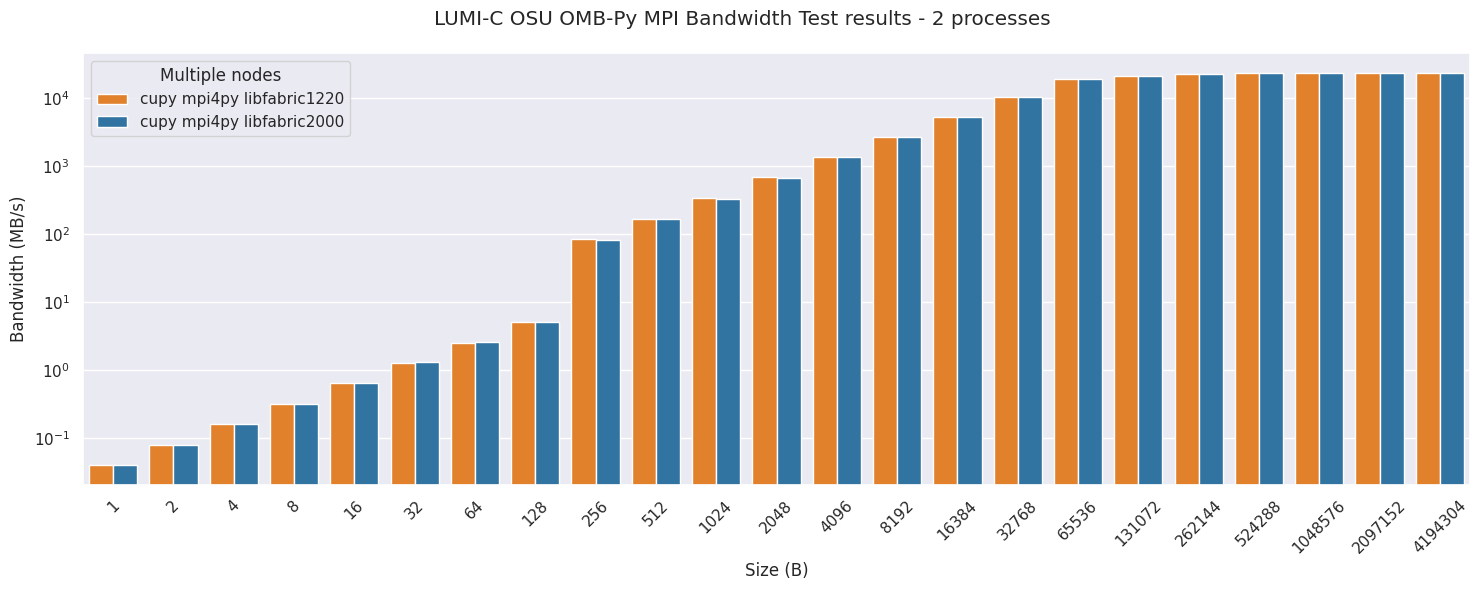

In [14]:
benchmark = "bw"; nodes='multi'
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Buffer='cupy', Nodes=nodes),
    benchmark=benchmark, nodes=nodes
)

Notably, at small byte-transfer sizes <= 128 the performance drop-off for GPU buffers, however the peak performance at large byte-transfer sizes is better for GPU buffers than CPU buffers.

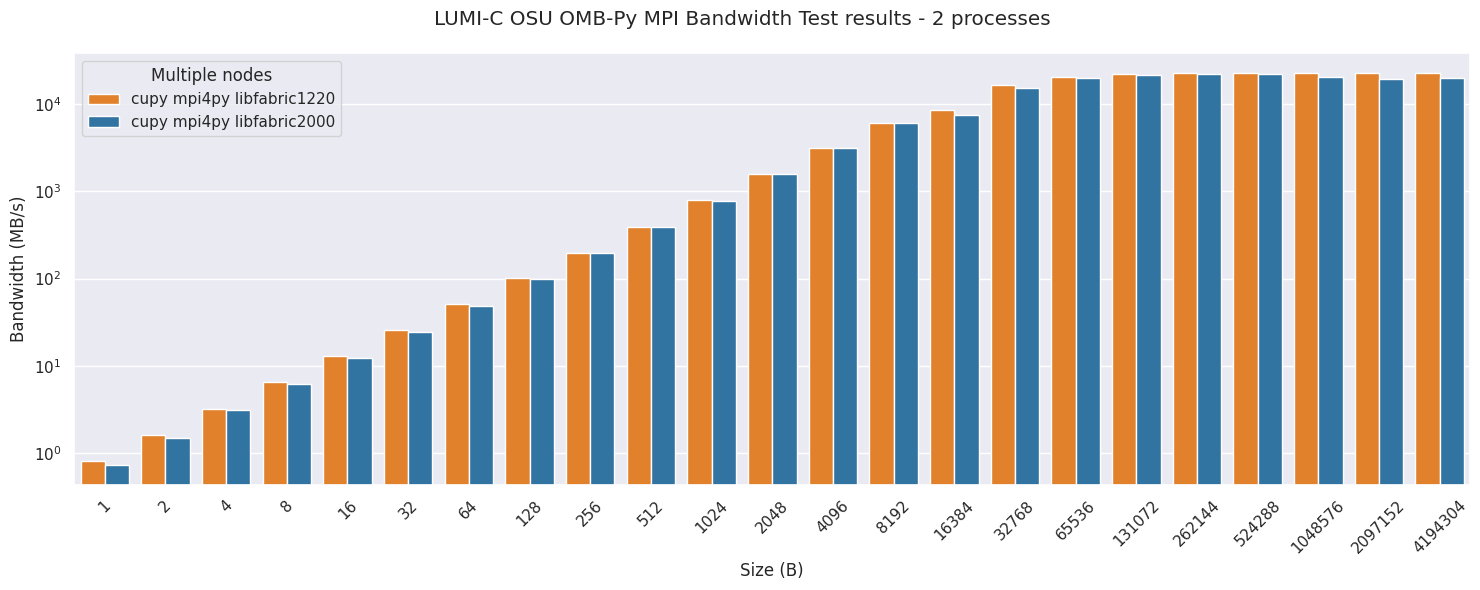

In [15]:
benchmark = "bw"; nodes='multi'
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Buffer='numpy', Container="cupy", Nodes=nodes),
    benchmark=benchmark, nodes=nodes
)

## CPU Latency test results

In [16]:
benchmark = "latency"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(lower is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric2000",  Buffer="numpy"),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB Python MPI Latency Test results - 2 processes
(lower is better)


Latency (us)                                        \
Container cupy mpi4py libfabric2000         mpi4py libfabric2000 extmpich   
Nodes                        single   multi                        single   
Buffer                        numpy   numpy                         numpy   
HMEM                           hmem    hmem                        nohmem   
Job                           lumig   lumig                         lumig   
Size (B)                                                                    
0                              1.33    2.92                          1.19   
1                              1.98    3.07                          1.83   
2                              1.97    3.07                          1.84   
4                              1.98    3.07                          1.81   
8                              1.97    3.07                          1.81   
16                             1.97    3.07                          1.81   
32                             1.96    3.07                          1.81   
64                             1.97    3.07                          1.81   
128                            1.97    3.60                          1.82   
256                            1.98    3.72                          1.83   
512                            2.01    3.75                          1.86   
1024                           2.05    3.84                          1.90   
2048                           2.11    3.97                          1.94   
4096                           2.22    4.16                          2.07   
8192                           2.45    7.21                          2.28   
16384                          4.21    8.46                          4.16   
32768                          5.42   10.37                          5.29   
65536                          7.47   13.10                          7.19   
131072                        13.01   17.86                         11.82   
262144                        25.68   26.94                         24.41   
524288                        48.16   40.73                         41.72   
1048576                       89.75   64.82                         73.82   
2097152                      154.80  106.64                        141.77   
4194304                      296.20  192.28                        272.25   

                                                                               \
Container                          mpi4py libfabric2000 pip                     
Nodes                multi                           single             multi   
Buffer               numpy                            numpy             numpy   
HMEM                nohmem                           nohmem            nohmem   
Job          lumic   lumig   lumic                    lumig    lumic    lumig   
Size (B)                                                                        
0             1.04    2.80    2.04                     0.72     1.27    17.40   
1             1.12    2.94    2.12                     0.75     1.35    17.39   
2             1.13    2.94    2.12                     0.75     1.44    17.40   
4             1.14    2.94    2.13                     0.75     1.38    17.40   
8             1.13    2.94    2.12                     0.75     1.36    17.38   
16            1.13    2.94    2.12                     0.75     1.36    17.56   
32            1.14    2.94    2.12                     0.75     1.31    17.40   
64            1.23    2.95    2.12                     0.75     1.35    17.64   
128           1.19    3.48    2.71                     0.75     1.33    17.55   
256           1.26    3.60    2.81                     0.76     1.42    21.76   
512           1.45    3.64    2.84                     0.80     1.61    24.56   
1024          1.72    3.72    2.94                     0.83     1.76    29.10   
2048          2.04    3.91    3.08                     0.88     2.24    25.90   
4096          2

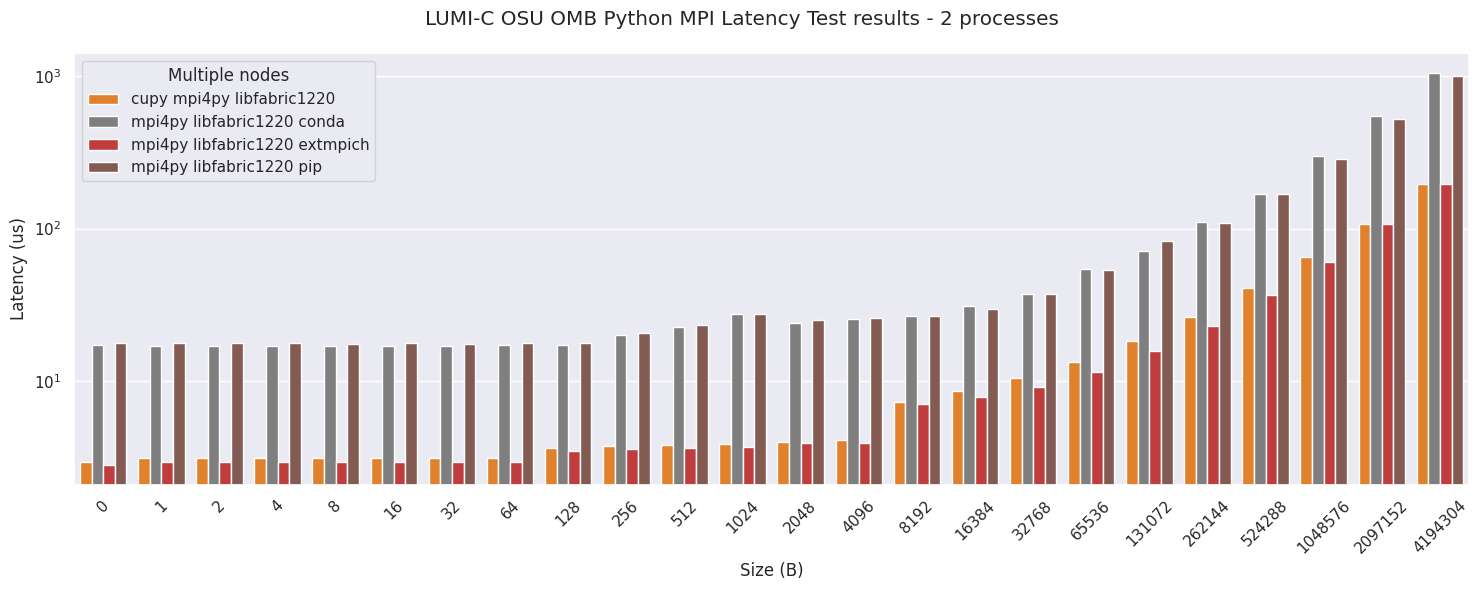

In [17]:
benchmark = "latency"; nodes = "multi"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric1220", Nodes=nodes, Buffer="numpy", Job='lumig'),
    benchmark=benchmark, nodes=nodes
)

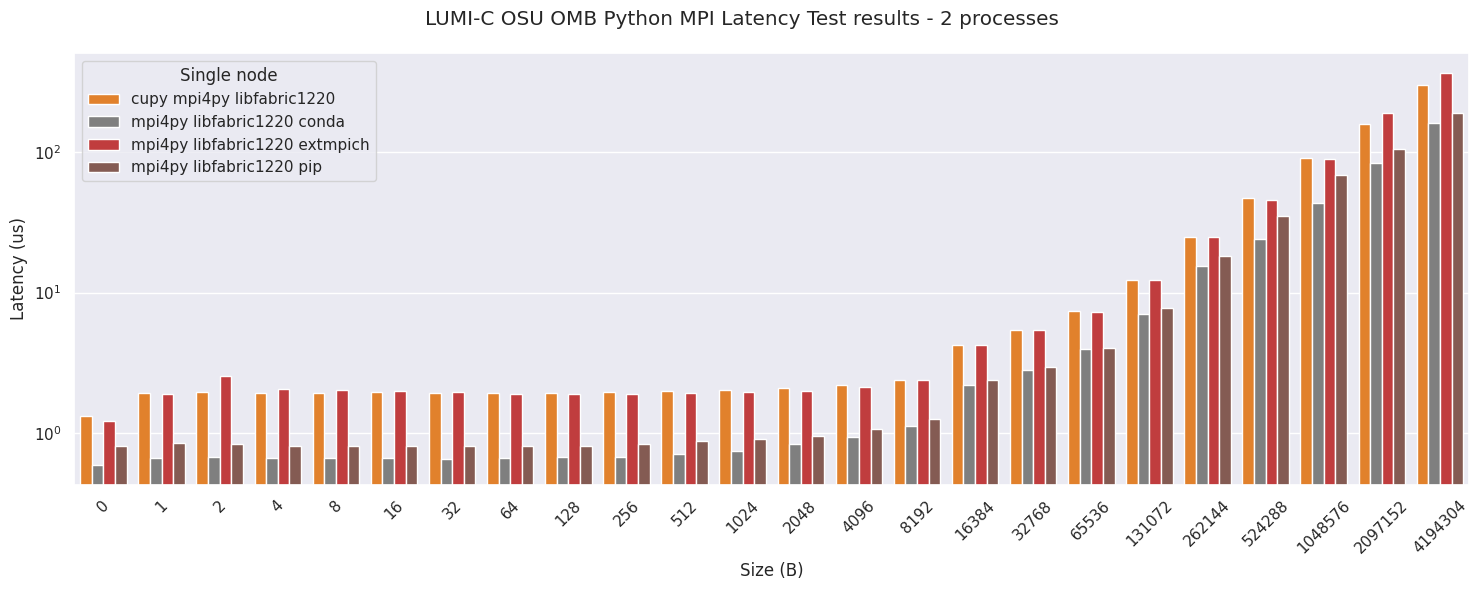

In [18]:
benchmark = "latency"; nodes = "single"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric1220", Nodes=nodes, Buffer="numpy", Job='lumig'),
    benchmark=benchmark, nodes=nodes
)

## Allgather CPU test results

In [19]:
benchmark = "allgather"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(lower is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric2000",  Buffer="numpy", Job='lumig'),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB Python MPI Allgather Test results - 3 processes
(lower is better)


Latency (us)                                        \
Container cupy mpi4py libfabric2000         mpi4py libfabric2000 extmpich   
Nodes                        single   multi                        single   
Buffer                        numpy   numpy                         numpy   
HMEM                           hmem    hmem                        nohmem   
Job                           lumig   lumig                         lumig   
Size (B)                                                                    
1                              2.57    8.78                          3.00   
2                              2.58    8.77                          2.89   
4                              2.56    8.76                          2.75   
8                              2.56    8.76                          2.66   
16                             2.55    8.78                          2.63   
32                             2.56    8.70                          2.56   
64                             2.57    8.80                          2.49   
128                            2.60    9.84                          2.47   
256                            2.59   11.18                          2.47   
512                            2.63   11.41                          2.50   
1024                           2.68   11.68                          2.53   
2048                           2.78   12.14                          2.63   
4096                           2.95   12.78                          2.80   
8192                           3.34   19.22                          3.13   
16384                          6.07   25.14                          6.01   
32768                          8.41   26.07                          8.39   
65536                         13.16   38.90                         12.70   
131072                        26.63   71.24                         25.33   
262144                        54.58  109.92                         61.54   
524288                        90.87  201.66                        123.26   
1048576                      165.06  406.14                        256.11   

                                                     \
Container         mpi4py libfabric2000 pip            
Nodes       multi                   single    multi   
Buffer      numpy                    numpy    numpy   
HMEM       nohmem                   nohmem   nohmem   
Job         lumig                    lumig    lumig   
Size (B)                                              
1            8.56                     1.13    41.34   
2            8.61                     1.13    41.85   
4            8.59                     1.13    41.16   
8            8.59                     1.13    41.77   
16           8.61                     1.13    41.80   
32           8.58                     1.13    41.88   
64           8.60                     1.14    42.14   
128          9.63                     1.15    42.07   
256         11.15                     1.14    78.24   
512         11.40                     1.20    72.90   
1024        11.62                     1.26   103.04   
2048        12.03                     1.34    85.01   
4096        12.49                     1.50    87.15   
8192        18.88                     1.91    89.92   
16384       24.66                     3.28    98.78   
32768       26.39                     4.93   122.00   
65536       38.19                     8.11   166.99   
131072      70.76                    18.90   238.59   
262144     106.18                    49.99   389.76   
524288     210.25                    77.93   672.52   
1048576    400.91                   119.94  1141.12   

                                               
Container mpi4py libfabric2000 conda           
Nodes                         single    multi  
Buffer                         numpy    numpy  
HMEM                          nohmem   nohmem  
Job                            lumig    lumig  
Size (B)                             

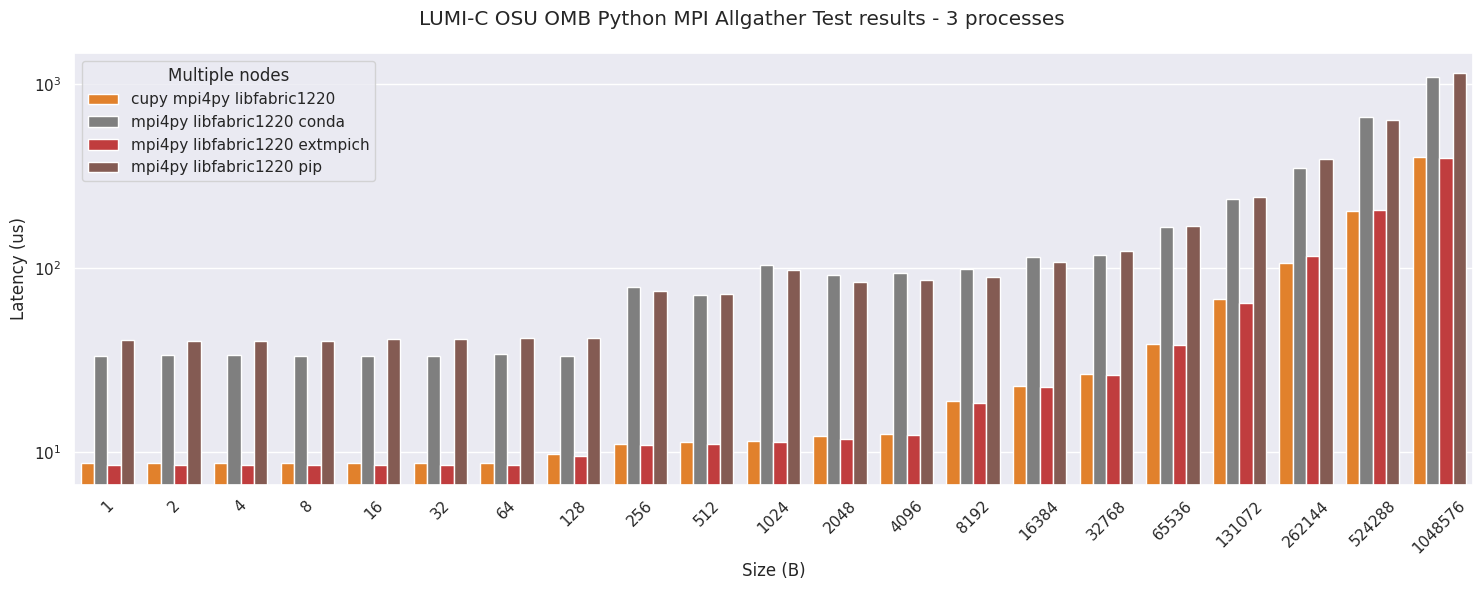

In [20]:
benchmark = "allgather"; nodes = "multi"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric1220", Nodes=nodes, Buffer="numpy", Job='lumig'),
    benchmark=benchmark, nodes=nodes
)

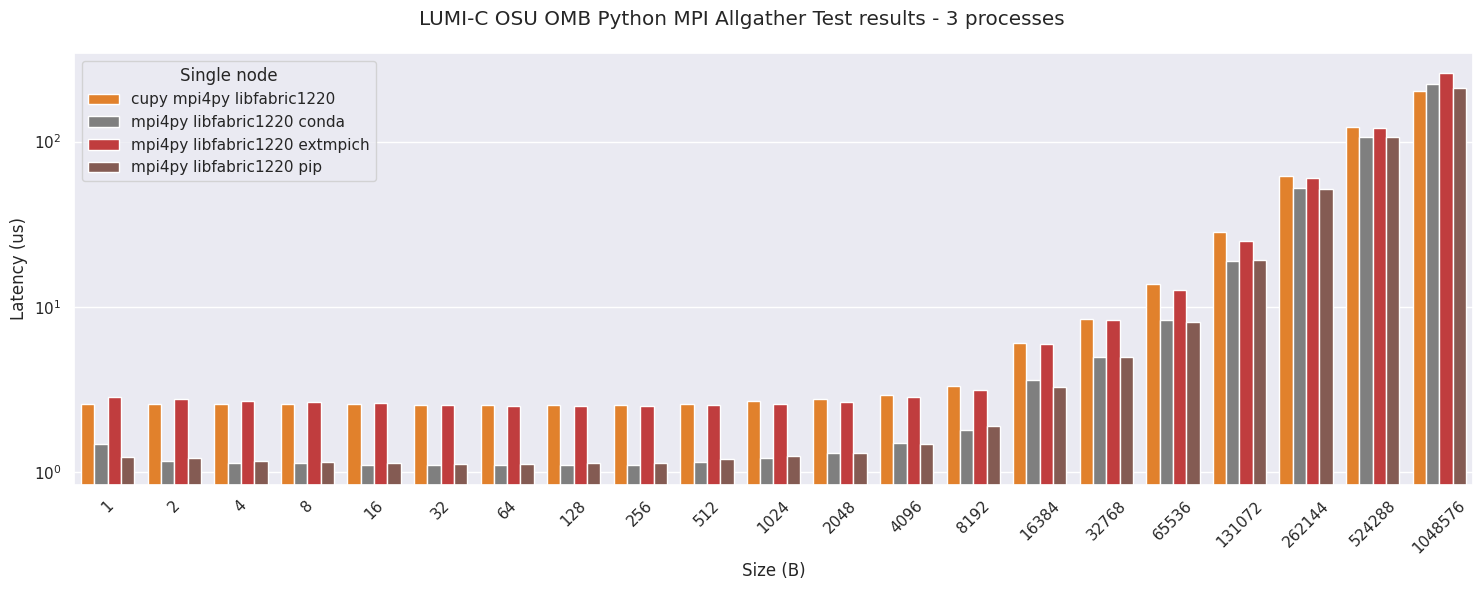

In [21]:
benchmark = "allgather"; nodes = "single"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Container="libfabric1220", Nodes=nodes, Buffer="numpy", Job='lumig'),
    benchmark=benchmark, nodes=nodes
)